# Assignment 4

Тема: Гибридные и распределённые параллельные вычисления

Задание 1 (25 баллов)
Реализуйте CUDA-программу для вычисления суммы элементов массива с
использованием глобальной памяти. Сравните результат и время выполнения с
последовательной реализацией на CPU для массива размером 100 000 элементов.

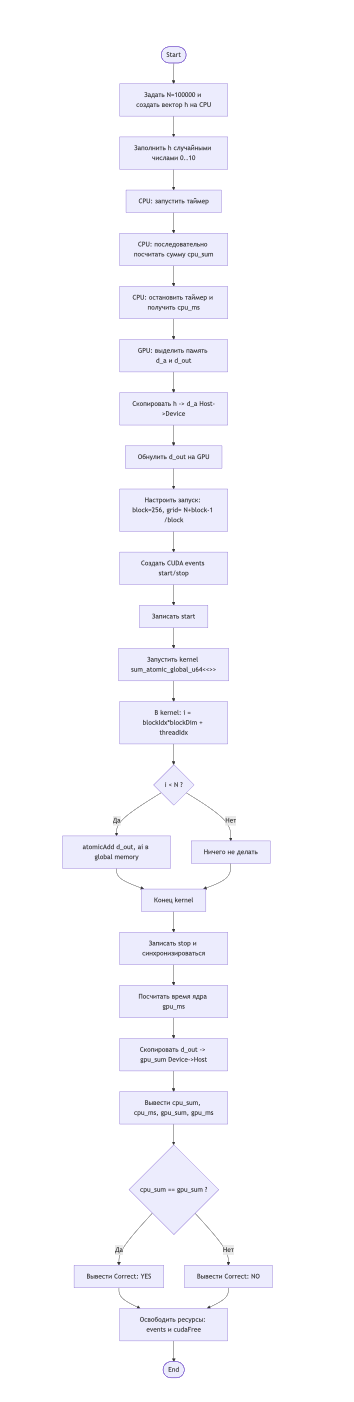

In [15]:
%%writefile task1_sum_global.cu
#include <cuda_runtime.h>              // CUDA runtime API
#include <cstdio>                      // printf
#include <vector>                      // std::vector
#include <random>                      // генератор случайных чисел
#include <chrono>                      // таймер CPU

#define CHECK(call) do { \
    cudaError_t e = (call); \
    if (e != cudaSuccess) { \
        printf("CUDA error %s:%d: %s\n", __FILE__, __LINE__, cudaGetErrorString(e)); \
        return 1; \
    } \
} while(0)

// CUDA kernel: суммирование через atomicAdd в глобальной памяти
__global__ void sum_atomic_global_u64(const int* a, int n, unsigned long long* out) { // out как unsigned long long*
    int i = blockIdx.x * blockDim.x + threadIdx.x;                                   // глобальный индекс
    if (i < n) {                                                                     // проверка границ
        atomicAdd(out, (unsigned long long)a[i]);                                    // atomicAdd поддержан для ULL
    }
}

int main() {
    const int N = 100000;                                                            // размер массива по заданию
    std::vector<int> h(N);                                                           // массив на CPU

    std::mt19937 rng(42);                                                            // seed
    std::uniform_int_distribution<int> dist(0, 10);                                  // значения 0..10
    for (int i = 0; i < N; i++) h[i] = dist(rng);                                    // заполняем

    // ---- CPU: последовательная сумма ----
    auto t1 = std::chrono::high_resolution_clock::now();                             // старт CPU таймера
    unsigned long long cpu_sum = 0;                                                  // сумма на CPU
    for (int i = 0; i < N; i++) cpu_sum += (unsigned long long)h[i];                 // считаем
    auto t2 = std::chrono::high_resolution_clock::now();                             // стоп CPU таймера
    double cpu_ms = std::chrono::duration<double, std::milli>(t2 - t1).count();      // CPU время

    // ---- GPU: выделение памяти ----
    int* d_a = nullptr;                                                              // массив на GPU
    unsigned long long* d_out = nullptr;                                             // сумма на GPU
    CHECK(cudaMalloc(&d_a, N * sizeof(int)));                                         // malloc под массив
    CHECK(cudaMalloc(&d_out, sizeof(unsigned long long)));                           // malloc под сумму
    CHECK(cudaMemcpy(d_a, h.data(), N * sizeof(int), cudaMemcpyHostToDevice));       // копируем массив
    CHECK(cudaMemset(d_out, 0, sizeof(unsigned long long)));                         // обнуляем сумму

    // ---- GPU: запуск и время ----
    int block = 256;                                                                 // потоки в блоке
    int grid  = (N + block - 1) / block;                                             // блоки

    cudaEvent_t start, stop;                                                         // CUDA события
    CHECK(cudaEventCreate(&start));                                                  // create start
    CHECK(cudaEventCreate(&stop));                                                   // create stop

    CHECK(cudaEventRecord(start));                                                   // старт времени
    sum_atomic_global_u64<<<grid, block>>>(d_a, N, d_out);                            // запуск ядра
    CHECK(cudaEventRecord(stop));                                                    // стоп времени
    CHECK(cudaEventSynchronize(stop));                                               // ждём завершения

    float gpu_ms = 0.0f;                                                             // время GPU ядра
    CHECK(cudaEventElapsedTime(&gpu_ms, start, stop));                               // считаем

    // ---- результат GPU ----
    unsigned long long gpu_sum = 0;                                                  // сумма на CPU
    CHECK(cudaMemcpy(&gpu_sum, d_out, sizeof(unsigned long long), cudaMemcpyDeviceToHost)); // copy back

    // ---- вывод ----
    printf("Task1 (N=%d)\n", N);                                                     // заголовок
    printf("CPU sum = %llu | time = %.3f ms\n", cpu_sum, cpu_ms);                     // CPU
    printf("GPU sum = %llu | kernel time = %.3f ms\n", gpu_sum, gpu_ms);              // GPU
    printf("Correct: %s\n", (cpu_sum == gpu_sum ? "YES" : "NO"));                     // проверка

    // ---- очистка ----
    cudaEventDestroy(start);                                                         // destroy
    cudaEventDestroy(stop);                                                          // destroy
    cudaFree(d_a);                                                                   // free
    cudaFree(d_out);                                                                 // free
    return 0;                                                                        // конец
}


Overwriting task1_sum_global.cu


In [16]:
!nvcc -O2 -arch=sm_75 task1_sum_global.cu -o task1_sum_global
!./task1_sum_global

Task1 (N=100000)
CPU sum = 499664 | time = 0.051 ms
GPU sum = 499664 | kernel time = 0.246 ms
Correct: YES


Вывод: При размере массива N=100000 результаты CPU и GPU полностью совпали (Correct: YES), значит реализация CUDA выполнена корректно. Однако по времени CPU оказался быстрее (0.051 ms против 0.246 ms на GPU), так как для небольшого массива накладные расходы и атомарные операции на GPU дают задержку.

Задание 2 (25 баллов)
Реализуйте CUDA-программу для вычисления префиксной суммы (сканирования)
массива с использованием разделяемой памяти. Сравните время выполнения с
последовательной реализацией на CPU для массива размером 1 000 000 элементов.

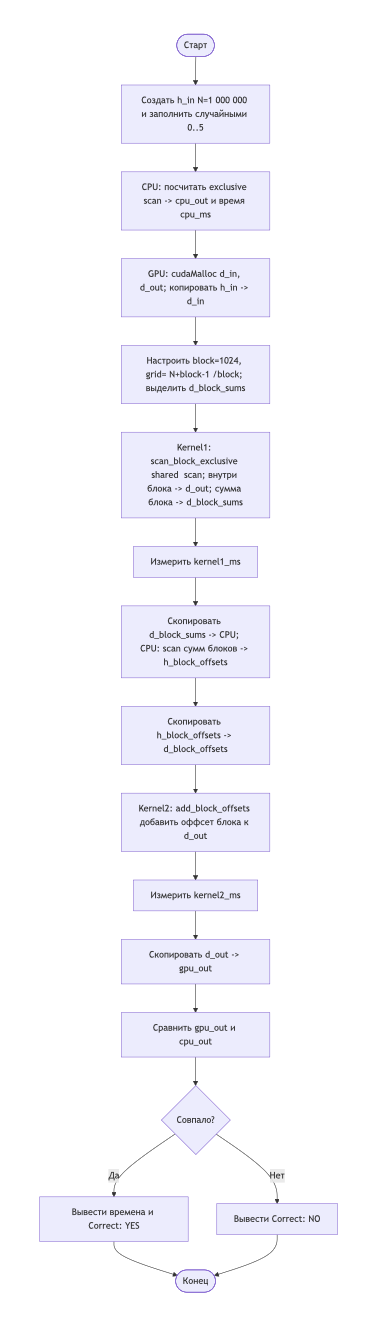


In [17]:
%%writefile task2_scan_shared.cu
#include <cuda_runtime.h>                  // CUDA runtime
#include <cstdio>                          // printf
#include <vector>                          // std::vector
#include <random>                          // random
#include <chrono>                          // CPU timer

#define CHECK(call) do { \
    cudaError_t e = (call); \
    if (e != cudaSuccess) { \
        printf("CUDA error %s:%d: %s\n", __FILE__, __LINE__, cudaGetErrorString(e)); \
        return 1; \
    } \
} while(0)

// ядро 1: делаем scan внутри каждого блока и сохраняем сумму блока
__global__ void scan_block_exclusive(const int* in, int* out, int* block_sums, int n) {
    extern __shared__ int s[];                                     // shared memory под элементы блока
    int tid = threadIdx.x;                                         // локальный индекс потока
    int gid = blockIdx.x * blockDim.x + tid;                       // глобальный индекс

    int x = (gid < n) ? in[gid] : 0;                               // берём элемент или 0 (padding)
    s[tid] = x;                                                    // кладём в shared
    __syncthreads();                                               // синхронизация

    // Blelloch scan: up-sweep (строим суммы)
    for (int offset = 1; offset < blockDim.x; offset <<= 1) {      // offset = 1,2,4,...
        int idx = (tid + 1) * offset * 2 - 1;                      // индекс вершины пары
        if (idx < blockDim.x) s[idx] += s[idx - offset];           // суммируем
        __syncthreads();                                           // синхронизация
    }

    // сохраняем сумму блока (последний элемент) и делаем exclusive
    if (tid == 0) {                                                // только один поток
        block_sums[blockIdx.x] = s[blockDim.x - 1];                // сумма блока
        s[blockDim.x - 1] = 0;                                     // превращаем в exclusive scan
    }
    __syncthreads();                                               // синхронизация

    // Blelloch scan: down-sweep (раскатываем)
    for (int offset = blockDim.x >> 1; offset >= 1; offset >>= 1) { // offset = B/2, B/4, ...
        int idx = (tid + 1) * offset * 2 - 1;                      // индекс вершины пары
        if (idx < blockDim.x) {                                    // проверка границ
            int t = s[idx - offset];                               // временно сохраняем левое
            s[idx - offset] = s[idx];                              // левое = правое
            s[idx] += t;                                           // правое += старое левое
        }
        __syncthreads();                                           // синхронизация
    }

    if (gid < n) out[gid] = s[tid];                                // записываем exclusive scan
}

// ядро 2: добавляем оффсет (scan по суммам блоков уже готов на CPU или GPU)
__global__ void add_block_offsets(int* out, const int* block_offsets, int n) {
    int gid = blockIdx.x * blockDim.x + threadIdx.x;               // глобальный индекс
    if (gid < n) {                                                 // границы
        int add = block_offsets[blockIdx.x];                       // оффсет блока
        out[gid] += add;                                           // добавляем
    }
}

int main() {
    const int N = 1000000;                                         // размер по заданию
    std::vector<int> h_in(N);                                      // вход на CPU
    std::mt19937 rng(7);                                           // seed
    std::uniform_int_distribution<int> dist(0, 5);                 // небольшие числа
    for (int i = 0; i < N; i++) h_in[i] = dist(rng);               // заполняем

    // ---- CPU scan (exclusive) ----
    std::vector<int> cpu_out(N);                                   // результат CPU
    auto c1 = std::chrono::high_resolution_clock::now();           // старт CPU
    long long run = 0;                                             // накопитель
    for (int i = 0; i < N; i++) {                                  // цикл
        cpu_out[i] = (int)run;                                     // exclusive
        run += h_in[i];                                            // обновляем сумму
    }
    auto c2 = std::chrono::high_resolution_clock::now();           // стоп CPU
    double cpu_ms = std::chrono::duration<double, std::milli>(c2 - c1).count(); // CPU время

    // ---- GPU память ----
    int* d_in = nullptr;                                           // вход на GPU
    int* d_out = nullptr;                                          // выход на GPU
    CHECK(cudaMalloc(&d_in, N * sizeof(int)));                      // malloc input
    CHECK(cudaMalloc(&d_out, N * sizeof(int)));                     // malloc output
    CHECK(cudaMemcpy(d_in, h_in.data(), N * sizeof(int), cudaMemcpyHostToDevice)); // copy input

    int block = 1024;                                              // размер блока (степень 2)
    int grid = (N + block - 1) / block;                            // число блоков

    int* d_block_sums = nullptr;                                   // суммы блоков на GPU
    CHECK(cudaMalloc(&d_block_sums, grid * sizeof(int)));           // malloc sums

    // ---- GPU scan внутри блоков ----
    cudaEvent_t start, stop;                                       // события CUDA
    CHECK(cudaEventCreate(&start));                                // create start
    CHECK(cudaEventCreate(&stop));                                 // create stop

    CHECK(cudaEventRecord(start));                                 // старт GPU
    scan_block_exclusive<<<grid, block, block * sizeof(int)>>>(d_in, d_out, d_block_sums, N); // scan blocks
    CHECK(cudaEventRecord(stop));                                  // стоп GPU
    CHECK(cudaEventSynchronize(stop));                             // ждём
    float kernel1_ms = 0.0f;                                       // время
    CHECK(cudaEventElapsedTime(&kernel1_ms, start, stop));         // измеряем

    // ---- делаем scan по block_sums на CPU (простое решение для Assignment) ----
    std::vector<int> h_block_sums(grid);                           // суммы блоков на CPU
    CHECK(cudaMemcpy(h_block_sums.data(), d_block_sums, grid * sizeof(int), cudaMemcpyDeviceToHost)); // копируем

    std::vector<int> h_block_offsets(grid);                        // оффсеты блоков (exclusive scan сумм)
    long long acc = 0;                                             // накопитель
    for (int i = 0; i < grid; i++) {                               // цикл
        h_block_offsets[i] = (int)acc;                             // exclusive offset
        acc += h_block_sums[i];                                    // добавляем сумму блока
    }

    int* d_block_offsets = nullptr;                                // оффсеты на GPU
    CHECK(cudaMalloc(&d_block_offsets, grid * sizeof(int)));        // malloc offsets
    CHECK(cudaMemcpy(d_block_offsets, h_block_offsets.data(), grid * sizeof(int), cudaMemcpyHostToDevice)); // copy

    // ---- GPU: добавляем оффсеты ----
    CHECK(cudaEventRecord(start));                                 // старт
    add_block_offsets<<<grid, block>>>(d_out, d_block_offsets, N);  // добавляем offsets
    CHECK(cudaEventRecord(stop));                                  // стоп
    CHECK(cudaEventSynchronize(stop));                             // ждём
    float kernel2_ms = 0.0f;                                       // время
    CHECK(cudaEventElapsedTime(&kernel2_ms, start, stop));         // измеряем

    // ---- копируем результат и проверяем ----
    std::vector<int> gpu_out(N);                                   // результат GPU на CPU
    CHECK(cudaMemcpy(gpu_out.data(), d_out, N * sizeof(int), cudaMemcpyDeviceToHost)); // copy back

    int bad = -1;                                                  // индекс ошибки
    for (int i = 0; i < N; i++) {                                  // проверка
        if (gpu_out[i] != cpu_out[i]) { bad = i; break; }          // если не совпало
    }

    printf("Task2 (exclusive scan, N=%d)\n", N);                   // заголовок
    printf("CPU time = %.3f ms\n", cpu_ms);                        // CPU время
    printf("GPU kernel1 (block scan) = %.3f ms\n", kernel1_ms);     // GPU ядро 1
    printf("GPU kernel2 (add offsets) = %.3f ms\n", kernel2_ms);    // GPU ядро 2
    printf("GPU total kernel = %.3f ms\n", kernel1_ms + kernel2_ms);// суммарно
    printf("Correct: %s", (bad == -1 ? "YES\n" : "NO\n"));         // корректность
    if (bad != -1) printf("First mismatch at i=%d: cpu=%d gpu=%d\n", bad, cpu_out[bad], gpu_out[bad]); // ошибка

    // ---- очистка ----
    cudaEventDestroy(start);                                       // destroy
    cudaEventDestroy(stop);                                        // destroy
    cudaFree(d_in);                                                // free
    cudaFree(d_out);                                               // free
    cudaFree(d_block_sums);                                        // free
    cudaFree(d_block_offsets);                                     // free
    return 0;                                                      // конец
}


Overwriting task2_scan_shared.cu


In [18]:
!nvcc -O2 -arch=sm_75 task2_scan_shared.cu -o task2_scan_shared
!./task2_scan_shared

Task2 (exclusive scan, N=1000000)
CPU time = 0.756 ms
GPU kernel1 (block scan) = 0.529 ms
GPU kernel2 (add offsets) = 0.071 ms
GPU total kernel = 0.599 ms
Correct: YES


Вывод: Для массива N=1 000 000 результаты CPU и GPU совпали (Correct: YES), значит алгоритм префиксной суммы на CUDA реализован корректно. По времени GPU оказался немного быстрее: суммарное время ядер 0.599 ms, тогда как CPU выполнил сканирование за 0.756 ms. Это связано с параллельной обработкой на GPU и использованием разделяемой памяти внутри блоков, что снижает задержки доступа к данным.

Задание 3 (25 баллов)
Реализуйте гибридную программу, в которой обработка массива выполняется
параллельно на CPU и GPU. Первую часть массива обработайте на CPU, вторую — на
GPU. Сравните время выполнения CPU-, GPU- и гибридной реализаций.

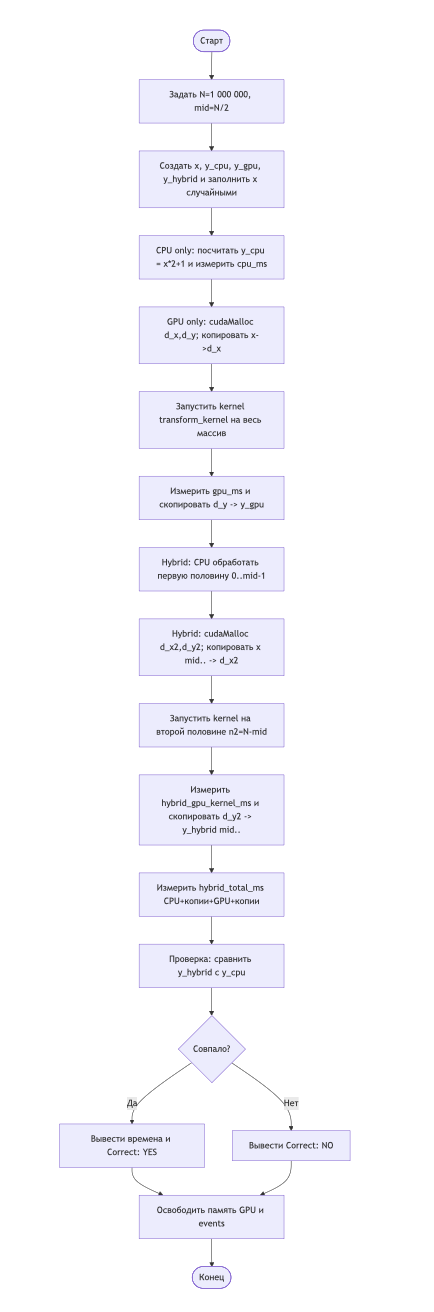

In [19]:
%%writefile task3_hybrid_cpu_gpu.cu
#include <cuda_runtime.h>
#include <cstdio>
#include <vector>
#include <random>
#include <chrono>

#define CHECK(call) do { \
    cudaError_t e = (call); \
    if (e != cudaSuccess) { \
        printf("CUDA error %s:%d: %s\n", __FILE__, __LINE__, cudaGetErrorString(e)); \
        return 1; \
    } \
} while(0)

// GPU kernel: простая обработка элементов
__global__ void transform_kernel(const float* x, float* y, int n) {
    int i = blockIdx.x * blockDim.x + threadIdx.x;          // индекс
    if (i < n) y[i] = x[i] * 2.0f + 1.0f;                   // операция
}

int main() {
    const int N = 1'000'000;                                // размер (можно оставить 1e6)
    const int mid = N / 2;                                  // граница: CPU | GPU

    std::vector<float> x(N), y_cpu(N), y_gpu(N), y_hybrid(N); // массивы
    std::mt19937 rng(123);
    std::uniform_real_distribution<float> dist(0.0f, 1.0f);
    for (int i = 0; i < N; i++) x[i] = dist(rng);           // вход

    // ---- CPU only ----
    auto c1 = std::chrono::high_resolution_clock::now();
    for (int i = 0; i < N; i++) y_cpu[i] = x[i] * 2.0f + 1.0f;
    auto c2 = std::chrono::high_resolution_clock::now();
    double cpu_ms = std::chrono::duration<double, std::milli>(c2 - c1).count();

    // ---- GPU only ----
    float *d_x = nullptr, *d_y = nullptr;
    CHECK(cudaMalloc(&d_x, N * sizeof(float)));
    CHECK(cudaMalloc(&d_y, N * sizeof(float)));
    CHECK(cudaMemcpy(d_x, x.data(), N * sizeof(float), cudaMemcpyHostToDevice));

    int block = 256;
    int grid = (N + block - 1) / block;

    cudaEvent_t s, t;
    CHECK(cudaEventCreate(&s));
    CHECK(cudaEventCreate(&t));

    CHECK(cudaEventRecord(s));
    transform_kernel<<<grid, block>>>(d_x, d_y, N);
    CHECK(cudaEventRecord(t));
    CHECK(cudaEventSynchronize(t));

    float gpu_ms = 0.0f;
    CHECK(cudaEventElapsedTime(&gpu_ms, s, t));

    CHECK(cudaMemcpy(y_gpu.data(), d_y, N * sizeof(float), cudaMemcpyDeviceToHost));

    // ---- Hybrid: CPU первая половина, GPU вторая половина ----
    // CPU часть
    auto h1 = std::chrono::high_resolution_clock::now();
    for (int i = 0; i < mid; i++) y_hybrid[i] = x[i] * 2.0f + 1.0f;

    // GPU часть: работаем только с диапазоном [mid..N)
    int n2 = N - mid;                                          // размер второй части
    float *d_x2 = nullptr, *d_y2 = nullptr;
    CHECK(cudaMalloc(&d_x2, n2 * sizeof(float)));
    CHECK(cudaMalloc(&d_y2, n2 * sizeof(float)));
    CHECK(cudaMemcpy(d_x2, x.data() + mid, n2 * sizeof(float), cudaMemcpyHostToDevice));

    int grid2 = (n2 + block - 1) / block;
    cudaEvent_t s2, t2;
    CHECK(cudaEventCreate(&s2));
    CHECK(cudaEventCreate(&t2));

    CHECK(cudaEventRecord(s2));
    transform_kernel<<<grid2, block>>>(d_x2, d_y2, n2);
    CHECK(cudaEventRecord(t2));
    CHECK(cudaEventSynchronize(t2));

    float hybrid_gpu_kernel_ms = 0.0f;
    CHECK(cudaEventElapsedTime(&hybrid_gpu_kernel_ms, s2, t2));

    CHECK(cudaMemcpy(y_hybrid.data() + mid, d_y2, n2 * sizeof(float), cudaMemcpyDeviceToHost));
    auto h2 = std::chrono::high_resolution_clock::now();
    double hybrid_total_ms = std::chrono::duration<double, std::milli>(h2 - h1).count();

    // ---- проверка ----
    int bad = -1;
    for (int i = 0; i < N; i++) {
        float a = y_cpu[i];
        float b = y_hybrid[i];
        if (fabs(a - b) > 1e-6f) { bad = i; break; }
    }

    printf("Task3 (Hybrid CPU+GPU) N=%d\n", N);
    printf("CPU only time = %.3f ms\n", cpu_ms);
    printf("GPU only kernel time = %.3f ms\n", gpu_ms);
    printf("Hybrid total time (CPU+copy+GPU+copy) = %.3f ms\n", hybrid_total_ms);
    printf("Hybrid GPU kernel part = %.3f ms\n", hybrid_gpu_kernel_ms);
    printf("Correct: %s\n", (bad == -1 ? "YES" : "NO"));

    // ---- очистка ----
    cudaEventDestroy(s);
    cudaEventDestroy(t);
    cudaEventDestroy(s2);
    cudaEventDestroy(t2);
    cudaFree(d_x);
    cudaFree(d_y);
    cudaFree(d_x2);
    cudaFree(d_y2);
    return 0;
}


Overwriting task3_hybrid_cpu_gpu.cu


In [20]:
!nvcc -O2 -arch=sm_75 task3_hybrid_cpu_gpu.cu -o task3_hybrid
!./task3_hybrid

Task3 (Hybrid CPU+GPU) N=1000000
CPU only time = 0.802 ms
GPU only kernel time = 0.089 ms
Hybrid total time (CPU+copy+GPU+copy) = 1.738 ms
Hybrid GPU kernel part = 0.020 ms
Correct: YES


Вывод: Результаты гибридной реализации совпали с CPU (Correct: YES), значит разделение массива между CPU и GPU выполнено правильно. Хотя вычисления на GPU выполняются очень быстро, гибридный вариант оказался самым медленным (1.738 ms), потому что основное время уходит на копирование данных между CPU и GPU и дополнительные накладные расходы.

Задание 4 (25 баллов)
Реализуйте распределённую программу с использованием MPI для обработки массива
данных. Разделите массив между процессами, выполните вычисления локально и
соберите результаты. Проведите замеры времени выполнения для 2, 4 и 8 процессов.

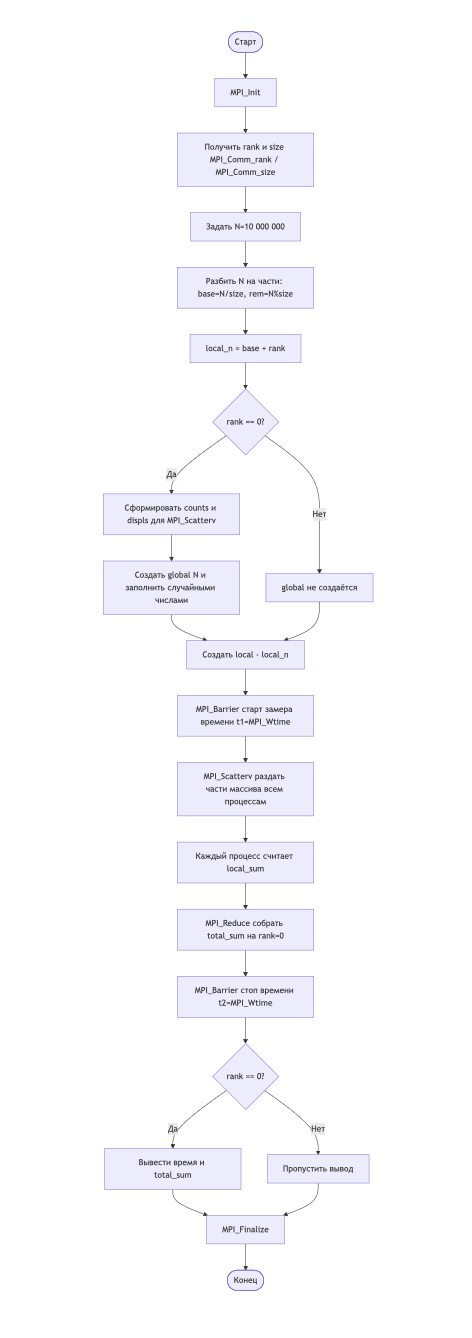

In [21]:
%%writefile task4_mpi_sum.cpp
#include <mpi.h>                         // MPI
#include <cstdio>                        // printf
#include <vector>                        // vector
#include <random>                        // random

int main(int argc, char** argv) {
    MPI_Init(&argc, &argv);              // инициализация MPI

    int rank = 0;                        // номер процесса
    int size = 1;                        // число процессов
    MPI_Comm_rank(MPI_COMM_WORLD, &rank);// получаем rank
    MPI_Comm_size(MPI_COMM_WORLD, &size);// получаем size

    const int N = 10'000'000;            // общий размер массива (можно менять)
    int base = N / size;                 // базовый размер куска
    int rem  = N % size;                 // остаток

    int local_n = base + (rank < rem ? 1 : 0); // сколько элементов у текущего процесса

    // считаем смещения для Scatterv
    std::vector<int> counts(size);       // сколько отправлять каждому
    std::vector<int> displs(size);       // смещения
    if (rank == 0) {                     // только root формирует
        int off = 0;                     // текущее смещение
        for (int r = 0; r < size; r++) { // по процессам
            counts[r] = base + (r < rem ? 1 : 0); // размер куска
            displs[r] = off;             // смещение
            off += counts[r];            // обновляем
        }
    }

    std::vector<int> global;             // глобальный массив только на root
    if (rank == 0) {                     // root создаёт данные
        global.resize(N);                // выделяем
        std::mt19937 rng(42);            // seed
        std::uniform_int_distribution<int> dist(0, 10);
        for (int i = 0; i < N; i++) global[i] = dist(rng); // заполняем
    }

    std::vector<int> local(local_n);     // локальный кусок у каждого процесса

    MPI_Barrier(MPI_COMM_WORLD);         // синхронизация перед временем
    double t1 = MPI_Wtime();             // старт времени

    MPI_Scatterv(                         // распределяем разные куски
        rank == 0 ? global.data() : nullptr, // sendbuf только у root
        counts.data(),                    // counts
        displs.data(),                    // displs
        MPI_INT,                          // тип
        local.data(),                     // recvbuf
        local_n,                          // recvcount
        MPI_INT,                          // тип
        0,                                // root
        MPI_COMM_WORLD                    // коммуникатор
    );

    long long local_sum = 0;             // локальная сумма
    for (int i = 0; i < local_n; i++) local_sum += local[i]; // считаем

    long long total_sum = 0;             // общий результат на root
    MPI_Reduce(                          // собираем сумму
        &local_sum,                      // send
        &total_sum,                      // recv на root
        1,                               // count
        MPI_LONG_LONG,                   // тип
        MPI_SUM,                         // операция
        0,                               // root
        MPI_COMM_WORLD                   // коммуникатор
    );

    MPI_Barrier(MPI_COMM_WORLD);         // синхронизация
    double t2 = MPI_Wtime();             // стоп времени

    if (rank == 0) {                     // печатаем только на root
        printf("Task4 MPI sum | N=%d | processes=%d | time=%.6f s | sum=%lld\n",
               N, size, (t2 - t1), total_sum);
    }

    MPI_Finalize();                      // завершаем MPI
    return 0;                            // конец
}


Overwriting task4_mpi_sum.cpp


In [22]:
!mpic++ -O2 task4_mpi_sum.cpp -o task4_mpi_sum
!mpirun --allow-run-as-root --oversubscribe -np 2 ./task4_mpi_sum
!mpirun --allow-run-as-root --oversubscribe -np 4 ./task4_mpi_sum
!mpirun --allow-run-as-root --oversubscribe -np 8 ./task4_mpi_sum



Task4 MPI sum | N=10000000 | processes=2 | time=0.012011 s | sum=49998331
Task4 MPI sum | N=10000000 | processes=4 | time=0.014373 s | sum=49998331
Task4 MPI sum | N=10000000 | processes=8 | time=0.024890 s | sum=49998331


Вывод: В распределённой реализации MPI сумма массива получилась одинаковой для 2, 4 и 8 процессов, что подтверждает корректность параллельного разбиения и сборки результата. Минимальное время выполнения наблюдается при 2 процессах (0.012 s), а при увеличении до 4 и 8 процессов время стало больше (0.014 s и 0.024 s), так как накладные расходы на обмен данными и синхронизацию начинают доминировать над выигрышем от параллелизма. Следовательно, для данного объёма данных оптимальным оказалось небольшое число процессов.

# Контрольные вопросы к Assignment 4
1. В чём заключается отличие гибридных вычислений от вычислений только на CPU или только на GPU?

Гибридные вычисления используют и CPU, и GPU вместе, распределяя работу между ними. CPU-only или GPU-only используют только одно устройство.

2. Для каких типов задач целесообразно распределять вычисления между CPU и GPU?

Для задач, где есть логика/управление (CPU) и массовые однотипные вычисления (GPU), например обработка больших массивов.

3. В чём разница между синхронной и асинхронной передачей данных между CPU и GPU?

Синхронная передача блокирует CPU и ждёт копирования. Асинхронная позволяет не ждать и выполнять другую работу.

4. Почему асинхронная передача данных может повысить производительность программы?

Потому что можно перекрывать копирование данных и вычисления, уменьшая простой CPU/GPU.

5. Какие основные функции MPI используются для распределения и сбора данных между процессами?

Основные функции MPI:передача данных MPI_Send, MPI_Recv (или MPI_Isend, MPI_Irecv), коллективные операции MPI_Bcast, MPI_Scatter, MPI_Gather, MPI_Reduce, а также синхронизация MPI_Barrier.

6. Как количество процессов MPI влияет на время выполнения программы и почему?

Сначала время уменьшается, но потом может расти из-за коммуникаций и синхронизации между процессами.

7. Какие факторы ограничивают масштабируемость распределённых параллельных программ?

Обмен данными между процессами, дисбаланс нагрузки, задержки сети, а также последовательная часть программы (закон Амдала).

8. В каких случаях использование распределённых вычислений оправдано, а в каких — неэффективно?

Оправданы для очень больших данных/задач, когда одной машины мало. Неэффективны для маленьких задач, где накладные расходы MPI слишком большие.